In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scipy.linalg
import scipy.integrate
import scipy.signal
import matplotlib.cm

## Goodwin's Oscillator

We will examine how the period is affected by each parameter in the system. Each state is produced at a rate proportional to $\alpha_{1,2,3}$ and destroyed at a rate proportional to $\gamma_{1,2,3}$. Z down-regulates X with activation threshold $K$ and Hill coefficient $n$.

<div style="max-width:200px;margin-left: auto; margin-right: auto;">
    
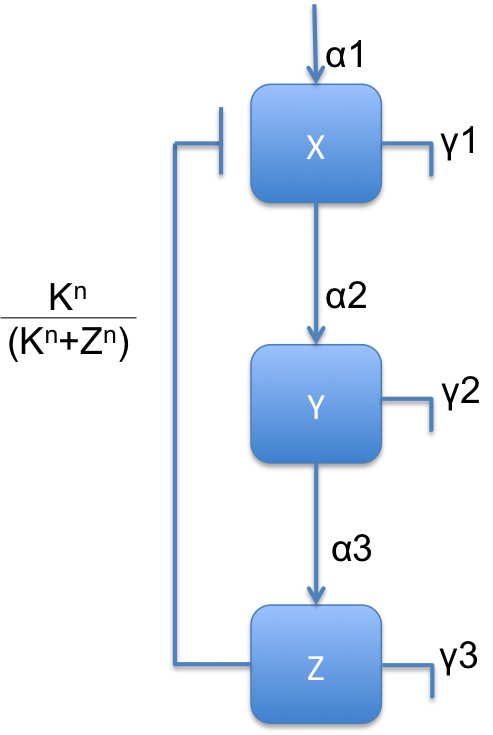
</div>

In [16]:
def goodwin_oscillator( t, statevars, params ):
    X = statevars[0];
    Y = statevars[1];
    Z = statevars[2];
    alpha_1 = params[0]
    K = params[1]
    n = params[2]
    gamma_1 = params[3]
    alpha_2 = params[4]
    gamma_2 = params[5]
    alpha_3 = params[6]
    gamma_3 = params[7]
        
    dydt = np.zeros( (3,) )
    dydt[0] = alpha_1*K**n/(K**n+Z**n) - gamma_1*X
    dydt[1] = alpha_2*X - gamma_2*Y;
    dydt[2] = alpha_3*Y - gamma_3*Z;

    return dydt


def get_period(t,x):
    """ Approximate the period of a 1-D x, given the time-steps t.
        Returns a tuple with the period and the standard deviation of the period over time.
        if the value of the standard deviation is not smaller than 0.1, then
        it means the period estimate is dodgy and you shouldn't use it. Instead,
        plot your simulation and figure out why it isn't periodic - maybe it just
        hasn't reached the limit cycle yet."""
    idxs = scipy.signal.find_peaks(x)
    idxs = idxs[0]
    times = t[idxs]
    period = np.mean(np.diff(times));
    sdperiod = np.sqrt(np.var(np.diff(times)));
    return (period,sdperiod)

In [68]:
def simulate_goodwin( params, t0=0, tStop=240, dt=0.1 ):
    """ Simulate the Goodwin oscillator with the given parameters
        at the given time steps and return the solution record. """
    yinit = np.ones((3,));
    sol = scipy.integrate.solve_ivp(fun=goodwin_oscillator, t_span=(0,10*24), y0=yinit, method='RK45', 
                                    t_eval=np.arange(0,10*24,0.1), args=[params] )
    sol = scipy.integrate.solve_ivp(fun=goodwin_oscillator, t_span=(0,10*24), y0=sol.y[:,-1], method='RK45', 
                                    t_eval=np.arange(t0,tStop,dt), args=[params], rtol=1e-8 )

    return sol

def goodwin_period( params ):
    """ Simulate the Goodwin oscillator with the given parameters
        and return the period (a scalar)
    """
    sol = simulate_goodwin( params )
    (per,sdper) = get_period( sol.t, sol.y[0,:] )
    return per

### Test the simulation and period function

period 22.240000000000002


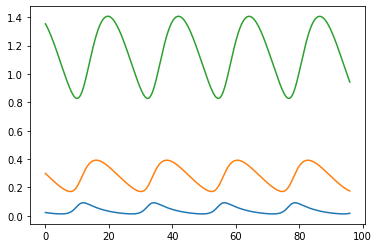

In [69]:
alpha_1 = 1
K = 0.61
n = 11
gamma_1 = 0.15
alpha_2 = 1
gamma_2 = 0.15
alpha_3 = 1
gamma_3 = 0.25

pub_params = [alpha_1,K,n,gamma_1,alpha_2,gamma_2,alpha_3,gamma_3]
param_names = ['alpha_1','K','n','gamma_1','alpha_2','gamma_2','alpha _3','gamma_3']

per = goodwin_period( pub_params )
print("period", per)

sol = simulate_goodwin( pub_params, tStop=4*24)
plt.plot( sol.t, sol.y.T );

### Write a general sensitivity function

Write a function that takes as input an "output" function (e.g. goodwin_period), a set of parameters, and the fraction each parameter should be perturbed.

Return the relative local parametric sensitvities for that output function to each of the parameters.

In [25]:
def sensitivity( fcn, ref_params, frac_change ):
    """
    fcn should be a handle to a function that takes a parameter set as input
        and returns a scalar as output.
    ref_params should be a 1D ndarray with the parameter set
    frac_change is the perturbation size, as a scale (i.e. the fraction by which you want to adjust the parameter by)
    """
    ref = fcn( ref_params );
    Srel = np.zeros((ref_params.size,));
    for i in range(ref_params.size):
        params = ref_params.copy();
        params[i] = (1+frac_change)*ref_params[i];
        output = fcn( params );
        Srel[i] = (output-ref)/frac_change;
    return Srel

### Test the sensitivity code

Compute the sensitivity to the period with the published parameters and a 5% perturbation.

In [54]:
Srel = sensitivity( goodwin_period, np.array(pub_params), 0.05 )

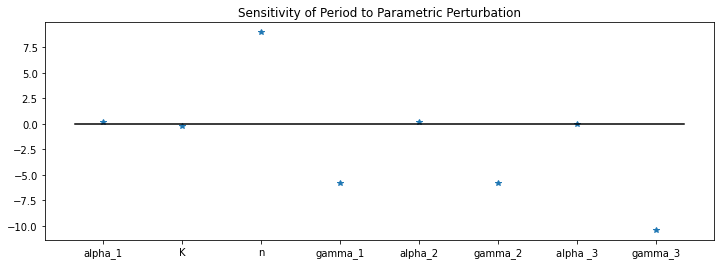

In [57]:
plt.figure(figsize=(12,4))
plt.plot( np.arange(len(pub_params)), Srel, '*')
plt.plot( plt.xlim(), [0, 0], 'k');
plt.xticks( ticks=np.arange(len(param_names)), labels=param_names);
plt.title( "Sensitivity of Period to Parametric Perturbation");